In [1]:
!pip install gym-jsbsim --user

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install gym==0.17.3 --user

You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import pkg_resources
pkg_resources.require("gym==0.17.3")
import gym
import gym_jsbsim
from gym_jsbsim.catalogs.catalog import Catalog as c
import numpy as np
import math
import random
import torch
from torch import nn
import torch.nn.functional as F

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
class PolicyNetwork(nn.Module):
    def __init__(self,num_hidden_neurons):
        super(PolicyNetwork, self).__init__()
        self.layer1 = nn.Linear(9,num_hidden_neurons)
        self.layer2 = nn.Linear(num_hidden_neurons,4)

    def forward(self, x):
        x=torch.tanh(self.layer1(x))
        x=torch.tanh(self.layer2(x))
        return x

In [6]:
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)
model = PolicyNetwork(16)
model.eval()
for param in model.parameters():
    param.requires_grad = False

In [7]:
def vec_to_weights(vec,num_hidden_neurons):
    w1 = torch.from_numpy(np.reshape(vec[0:num_hidden_neurons*9], (num_hidden_neurons, 9))).float()
    w2 = torch.from_numpy(np.reshape(vec[num_hidden_neurons*9:13*num_hidden_neurons], (4, num_hidden_neurons))).float()
    b1 = torch.from_numpy(np.reshape(vec[num_hidden_neurons*13:14*num_hidden_neurons], (num_hidden_neurons))).float()
    b2 = torch.from_numpy(np.reshape(vec[num_hidden_neurons*14:14*num_hidden_neurons+4], (4))).float()
    return w1,w2,b1,b2

In [8]:
class Obs_TupleToBoxWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        low = np.empty(shape=(0,))
        high = np.empty(shape=(0,))
        for i in env.observation_space:
            low = np.concatenate([low,i.low])
            high = np.concatenate([high,i.high])
        self.observation_space = gym.spaces.Box(low=low, high=high, dtype="float")
        
    
    def observation(self, obs):
        new_obs = np.empty(shape=(0,))
        for i in obs:
            new_obs = np.concatenate([new_obs,i])
        return new_obs

In [9]:
class Act_TupleToBoxWrapper(gym.ActionWrapper):
    def __init__(self, env):
        super().__init__(env)
        low = np.empty(shape=(0,))
        high = np.empty(shape=(0,))
        for i in env.action_space:
            low = np.concatenate([low,i.low])
            high = np.concatenate([high,i.high])
        self.action_space = gym.spaces.Box(low=low, high=high, dtype="float")
        
    
    def action(self, act):
        return act

In [10]:
env=Act_TupleToBoxWrapper(Obs_TupleToBoxWrapper(gym.make("GymJsbsim-HeadingControlTask-v0")))

In [11]:
def find_and_take_action(env,curr_state,nn):
    action = nn(torch.from_numpy(curr_state).float())
    action.numpy()
    action[-1]=(action[-1]+1)*0.45
    state, reward, done, _ = env.step(action)
    return state, reward, done

In [12]:
def run_episode(env,nn,find_and_take_action):
    episode_reward = 0
    state = env.reset()
    #print("Initial State =", state)
    done = False
    while not done:
        state, reward, done = find_and_take_action(env,state,nn)
        episode_reward += reward

    delta_heading_altitude = (1/(abs(state[0])+1))*(1/(abs(state[1])+1))
        
    return env.get_sim_time(),episode_reward,delta_heading_altitude

In [13]:
import pickle
with open('./weights/58308.pickle', 'rb') as handle:
    d = pickle.load(handle)

In [14]:
print("Time: ",d["times_final"][-3]," sec")
print("Reward: ",d["episode_rewards_final"][-3])

Time:  7542.4999999743895  sec
Reward:  17613.03651317054


In [15]:
w1, w2, b1, b2 = vec_to_weights(d["centers_final"][-3],16)
model.layer1.weight.data = w1
model.layer2.weight.data = w2
model.layer1.bias.data = b1
model.layer2.bias.data = b2

In [16]:
times = []
episode_rewards = []

for i in range(100):
    print(i)
    random.seed(i)
    t, r, _ = run_episode(env,model,find_and_take_action)
    times.append(t)
    episode_rewards.append(r)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [17]:
import statistics
print(statistics.mean(times))
print(statistics.stdev(times))

print(statistics.mean(episode_rewards))
print(statistics.stdev(episode_rewards))

6014.1124999844815
2310.9431897960717
13144.390185330685
5131.9445753192085


In [18]:
max(times)

7863.916666636379

In [19]:
max(episode_rewards)

18499.41497476356

In [20]:
min(times)

2250.166666667707

In [21]:
min(episode_rewards)

5249.764487892753

In [22]:
episode_rewards.index(max(episode_rewards))

13

In [23]:
times[13]

7682.583333305684

In [24]:
times.index(max(times))

84

In [25]:
episode_rewards[84]

16037.0366523051

In [26]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Time (in sec)')

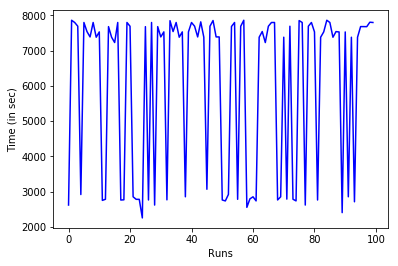

In [27]:
plt.plot(range(100),times, c='blue')
plt.xlabel('Runs')
plt.ylabel('Time (in sec)')

Text(0, 0.5, 'Reward')

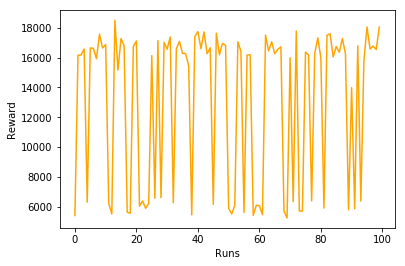

In [28]:
plt.plot(range(100),episode_rewards, c='orange')
plt.xlabel('Runs')
plt.ylabel('Reward')

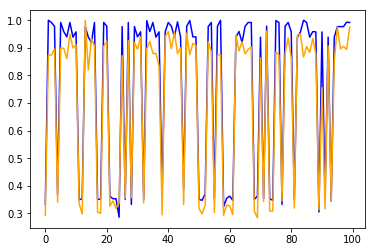

In [29]:
plt.plot(range(100),[x / max(times) for x in times], c='blue')
plt.plot(range(100),[x / max(episode_rewards) for x in episode_rewards], c='orange')

In [30]:
def run_episode_analysis(env,nn,find_and_take_action):
    episode_reward = 0
    da = []
    dh = []
    t = []
    state = env.reset()
    da.append(state[0])
    dh.append(state[1])
    t.append(env.get_sim_time())
    #print("Initial State =", state)
    done = False
    while not done:
        state, reward, done = find_and_take_action(env,state,nn)
        da.append(state[0])
        dh.append(state[1])
        t.append(env.get_sim_time())
        episode_reward += reward

    return da,dh,t,episode_reward

In [31]:
times[-1]

7800.0833333039745

In [32]:
env.get_sim_time()

7800.0833333039745

In [33]:
import time

In [34]:
start = time.time()
random.seed(13)
da,dh,t,episode_reward = run_episode_analysis(env,model,find_and_take_action)
end = time.time()
print(end-start)

68.3553900718689


In [35]:
episode_reward

18499.41497476356

Text(0, 0.5, 'Delta Altitude')

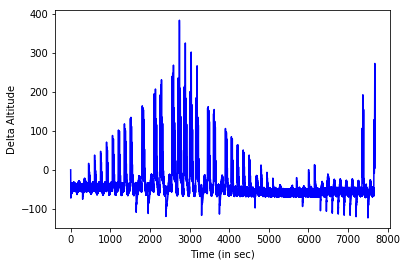

In [36]:
plt.plot(t,da, c='blue')
plt.xlabel('Time (in sec)')
plt.ylabel('Delta Altitude')

Text(0, 0.5, 'Delta Heading')

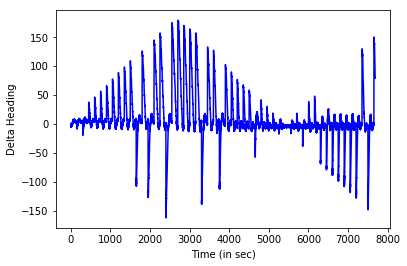

In [37]:
plt.plot(t,dh, c='blue')
plt.xlabel('Time (in sec)')
plt.ylabel('Delta Heading')

In [38]:
episode_rewards.index(min(episode_rewards))

69

In [40]:
min(episode_rewards)

5249.764487892753

In [39]:
episode_rewards[69]

5249.764487892753

In [41]:
times[69]

2850.000000008678

In [42]:
start = time.time()
random.seed(69)
da,dh,t,episode_reward = run_episode_analysis(env,model,find_and_take_action)
end = time.time()
print(end-start)

24.484536170959473


In [43]:
episode_reward

5249.764487892753

Text(0, 0.5, 'Delta Altitude')

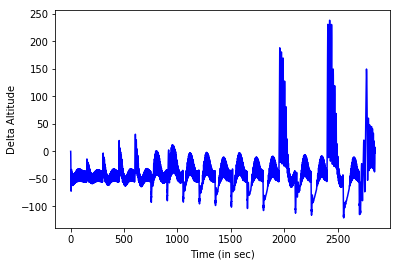

In [44]:
plt.plot(t,da, c='blue')
plt.xlabel('Time (in sec)')
plt.ylabel('Delta Altitude')

Text(0, 0.5, 'Delta Heading')

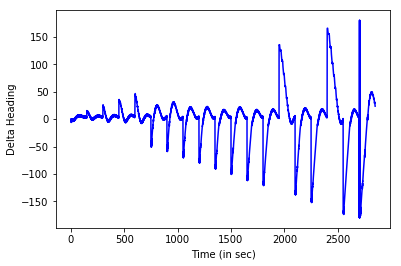

In [45]:
plt.plot(t,dh, c='blue')
plt.xlabel('Time (in sec)')
plt.ylabel('Delta Heading')